In [1]:
import os
import pandas as pd
import re

from plotnine import *
from plotnine import options

In [2]:
MAIN_KEY_SIZE = 'size'
MAIN_KEY_APPROACH = 'approach'

phase_order = [
    'RADIANCE',
    'REFLECTANCE',
    'RAD_REF',
    'ALBEDO',
    'NDVI',
    'PAI',
    'LAI',
    'EVI',
    'ENB_EMISSIVITY',
    'EO_EMISSIVITY',
    'EA_EMISSIVITY',
    'SURFACE_TEMPERATURE',
    'SHORT_WAVE_RADIATION',
    'LARGE_WAVE_RADIATION_SURFACE',
    'LARGE_WAVE_RADIATION_ATMOSPHERE',
    'NET_RADIATION',
    'SOIL_HEAT_FLUX',
    'PIXEL_FILTER',
    'D0',
    'ZOM',
    'USTAR',
    'KB1',
    'RAH_INI',
    'RAH_CYCLE_0',
    'RAH_CYCLE_1',
    'RAH_CYCLE_2',
    'RAH_CYCLE_3',
    'SENSIBLE_HEAT_FLUX',
    'LATENT_HEAT_FLUX',
    'NET_RADIATION_24H',
    'EVAPOTRANSPIRATION_FRACTION',
    'SENSIBLE_HEAT_FLUX_24H',
    'LATENT_HEAT_FLUX_24H',
    'EVAPOTRANSPIRATION_24H',
    'EVAPOTRANSPIRATION',
    'P0_READ_INPUT',
    'P1_INITIAL_PROD',
    'P2_PIXEL_SEL',
    'P3_RAH',
    'P4_FINAL_PROD',
    'P_TOTAL',
]

size_order = ["455","911","1823","3647","7295"]


## Aux functions

In [3]:
def get_mode(series):
    """Função para obter a moda de uma série."""
    mode_values = series.mode()
    # Retorna o primeiro valor da moda se houver múltiplos valores
    return mode_values.iloc[0] if not mode_values.empty else None

def combine_dfs(base_dir):
    dataframes = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        if 'time.csv' in files:
            # Read the CSV file and append the DataFrame to the list
            df = pd.read_csv(os.path.join(root, 'time.csv'))
            dataframes.append(df[['PHASE', 'TIMESTAMP']])

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
    else:
        combined_df = pd.DataFrame()  # Empty DataFrame if no files found

    return combined_df

In [4]:
def extract_size(key):
    match = re.search(r'(\d+)$', key)
    return int(match.group(1)) if match else None

def consolidate_dataframes(dic_mean_times, main_key=MAIN_KEY_SIZE):
    consolidated_data = []
    
    for key, df in dic_mean_times.items():
        # Extrai o tamanho (size) da chave
        size = extract_size(key)
        name = key.split('-')[0]

        df['experiment'] = key
        if main_key == MAIN_KEY_SIZE:
            df['size'] = size
            df = df[['size', 'PHASE', 'TIMESTAMP', 'experiment']]
        elif main_key == MAIN_KEY_APPROACH:
            df['approach'] = name
            df = df[['approach', 'PHASE', 'TIMESTAMP', 'experiment']]
                
        # Adiciona o DataFrame à lista consolidada
        consolidated_data.append(df)
    
    # Concatena todos os DataFrames da lista em um único DataFrame
    combined_df = pd.concat(consolidated_data, ignore_index=True)
    
    # Usa pivot para reorganizar o DataFrame de acordo com o formato desejado
    pivot_df = combined_df.pivot_table(
        index=[main_key, 'PHASE'],
        columns='experiment',
        values='TIMESTAMP',
        aggfunc='mean'
    ).reset_index()
    
    # Renomeia as colunas para remover o prefixo criado pelo pivot
    pivot_df.columns.name = None
    
    return pivot_df

# Summarize

In [5]:
directories = {
    "./output": [
        "cpp-sebal-6502x1823","cpp-sebal-6502x3647","cpp-sebal-6502x455","cpp-sebal-6502x911", "cpp-sebal-6502x7295", #"cpp-sebal-6502x227
        "cpp-steep-6502x1823","cpp-steep-6502x3647","cpp-steep-6502x455","cpp-steep-6502x911", "cpp-steep-6502x7295", #"cpp-steep-6502x227
        "kernels-sebal-6502x1823","kernels-sebal-6502x3647","kernels-sebal-6502x455","kernels-sebal-6502x911", "kernels-sebal-6502x7295", #"kernels-sebal-6502x227
        "kernels-steep-6502x1823","kernels-steep-6502x3647","kernels-steep-6502x455","kernels-steep-6502x911", "kernels-steep-6502x7295", #"kernels-steep-6502x227
        "cutensor-sebal-6502x1823","cutensor-sebal-6502x3647","cutensor-sebal-6502x455","cutensor-sebal-6502x7295","cutensor-sebal-6502x911", #"cutensor-sebal-6502x227
        "cutensor-steep-6502x1823","cutensor-steep-6502x3647","cutensor-steep-6502x455","cutensor-steep-6502x7295","cutensor-steep-6502x911", #"cutensor-steep-6502x227
        "hybrid-sebal-6502x1823","hybrid-sebal-6502x3647","hybrid-sebal-6502x455","hybrid-sebal-6502x911", "hybrid-sebal-6502x7295", #"hybrid-sebal-6502x227
        "hybrid-steep-6502x1823","hybrid-steep-6502x3647","hybrid-steep-6502x455","hybrid-steep-6502x911", "hybrid-steep-6502x7295", #"hybrid-steep-6502x227
    ]
}

dic_combined = dict()
for dir, subdirs in directories.items():
    for subdir in subdirs:
        subdir_path = os.path.join(dir, subdir)
        dic_combined[subdir] = combine_dfs(subdir_path)

dic_summarized = dict()
for key in dic_combined.keys():
    combined_df = dic_combined[key]
    combined_df.groupby('PHASE')
    summarized = combined_df.groupby('PHASE')['TIMESTAMP'].mean().reset_index()
    # summarized = combined_df.groupby('PHASE')['TIMESTAMP'].apply(get_mode).reset_index()

    summarized['PHASE'] = pd.Categorical(
        summarized['PHASE'], 
        categories=phase_order, 
        ordered=True
    )
    
    summarized = summarized.sort_values('PHASE').reset_index(drop=True)

    dic_summarized[key] = summarized


In [6]:
dic_summarized["cutensor-sebal-6502x7295"]

,PHASE,TIMESTAMP
0,RADIANCE,6.836512
1,REFLECTANCE,7.509709
2,RAD_REF,6.436981
3,ALBEDO,5.360518
4,NDVI,2.098176
5,PAI,1.866808
6,LAI,8.516790
7,EVI,3.903960
8,ENB_EMISSIVITY,1.196124
9,EO_EMISSIVITY,1.202639


# Approaches comparation

In [7]:
# Executa a função para consolidar os DataFrames
final_df = consolidate_dataframes(dic_summarized, MAIN_KEY_SIZE)
final_df = final_df[final_df['size'] == 7295].dropna(axis=1, how='all')

/tmp/ipykernel_189344/3307954039.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [8]:
# Exibe o DataFrame consolidado
final_df

,size,PHASE,cpp-sebal-6502x7295,cpp-steep-6502x7295,cutensor-sebal-6502x7295,cutensor-steep-6502x7295,hybrid-sebal-6502x7295,hybrid-steep-6502x7295,kernels-sebal-6502x7295,kernels-steep-6502x7295
164,7295,RADIANCE,925.270364,927.953916,6.836512,6.838941,3.875344,3.869983,4.045704,4.041641
165,7295,REFLECTANCE,972.786372,974.874587,7.509709,7.509626,3.388720,3.390015,3.375672,3.377384
166,7295,RAD_REF,NaN,NaN,6.436981,6.440789,NaN,NaN,NaN,NaN
167,7295,ALBEDO,300.071959,299.874317,5.360518,5.363689,4.023878,4.023830,4.013148,3.998749
168,7295,NDVI,172.169716,172.147012,2.098176,2.097004,0.713562,0.712626,0.708234,0.709332
169,7295,PAI,169.910178,169.881371,1.866808,1.865192,1.051792,1.052363,1.036297,1.034884
170,7295,LAI,470.072805,469.868186,8.516790,8.511356,8.491740,8.487922,8.484219,8.456937
171,7295,EVI,186.465662,186.417379,3.903960,3.902902,4.414633,4.413146,4.405559,4.392638
172,7295,ENB_EMISSIVITY,140.775912,141.717127,1.196124,1.195903,1.182403,1.181619,1.171996,1.167270
173,7295,EO_EMISSIVITY,141.282054,141.306492,1.202639,1.201326,1.183881,1.181439,1.169945,1.168648


In [9]:
final_df[~final_df['PHASE'].str.startswith('P')]

,size,PHASE,cpp-sebal-6502x7295,cpp-steep-6502x7295,cutensor-sebal-6502x7295,cutensor-steep-6502x7295,hybrid-sebal-6502x7295,hybrid-steep-6502x7295,kernels-sebal-6502x7295,kernels-steep-6502x7295
164,7295,RADIANCE,925.270364,927.953916,6.836512,6.838941,3.875344,3.869983,4.045704,4.041641
165,7295,REFLECTANCE,972.786372,974.874587,7.509709,7.509626,3.388720,3.390015,3.375672,3.377384
166,7295,RAD_REF,NaN,NaN,6.436981,6.440789,NaN,NaN,NaN,NaN
167,7295,ALBEDO,300.071959,299.874317,5.360518,5.363689,4.023878,4.023830,4.013148,3.998749
168,7295,NDVI,172.169716,172.147012,2.098176,2.097004,0.713562,0.712626,0.708234,0.709332
170,7295,LAI,470.072805,469.868186,8.516790,8.511356,8.491740,8.487922,8.484219,8.456937
171,7295,EVI,186.465662,186.417379,3.903960,3.902902,4.414633,4.413146,4.405559,4.392638
172,7295,ENB_EMISSIVITY,140.775912,141.717127,1.196124,1.195903,1.182403,1.181619,1.171996,1.167270
173,7295,EO_EMISSIVITY,141.282054,141.306492,1.202639,1.201326,1.183881,1.181439,1.169945,1.168648
174,7295,EA_EMISSIVITY,820.283664,820.359770,2.124174,2.120760,4.247376,4.249990,15.485957,15.427288


In [10]:
filtered_phases = final_df[~final_df['PHASE'].str.match(r'^P.\_') & (final_df['PHASE'] != 'P_TOTAL')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,size,PHASE,cpp-sebal-6502x7295,cpp-steep-6502x7295,cutensor-sebal-6502x7295,cutensor-steep-6502x7295,hybrid-sebal-6502x7295,hybrid-steep-6502x7295,kernels-sebal-6502x7295,kernels-steep-6502x7295
164,7295.0,RADIANCE,925.270364,927.953916,6.836512,6.838941,3.875344,3.869983,4.045704,4.041641
165,7295.0,REFLECTANCE,972.786372,974.874587,7.509709,7.509626,3.388720,3.390015,3.375672,3.377384
166,7295.0,RAD_REF,NaN,NaN,6.436981,6.440789,NaN,NaN,NaN,NaN
167,7295.0,ALBEDO,300.071959,299.874317,5.360518,5.363689,4.023878,4.023830,4.013148,3.998749
168,7295.0,NDVI,172.169716,172.147012,2.098176,2.097004,0.713562,0.712626,0.708234,0.709332
169,7295.0,PAI,169.910178,169.881371,1.866808,1.865192,1.051792,1.052363,1.036297,1.034884
170,7295.0,LAI,470.072805,469.868186,8.516790,8.511356,8.491740,8.487922,8.484219,8.456937
171,7295.0,EVI,186.465662,186.417379,3.903960,3.902902,4.414633,4.413146,4.405559,4.392638
172,7295.0,ENB_EMISSIVITY,140.775912,141.717127,1.196124,1.195903,1.182403,1.181619,1.171996,1.167270
173,7295.0,EO_EMISSIVITY,141.282054,141.306492,1.202639,1.201326,1.183881,1.181439,1.169945,1.168648


In [11]:
filtered_phases = final_df[final_df['PHASE'].str.match(r'^P.\_')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,size,PHASE,cpp-sebal-6502x7295,cpp-steep-6502x7295,cutensor-sebal-6502x7295,cutensor-steep-6502x7295,hybrid-sebal-6502x7295,hybrid-steep-6502x7295,kernels-sebal-6502x7295,kernels-steep-6502x7295
199,7295.0,P0_READ_INPUT,2139.181284,2139.078772,2536.144609,2532.245565,2566.167826,2565.895345,2352.061966,2352.949217
200,7295.0,P1_INITIAL_PROD,5272.891046,5278.994809,1991.732367,1990.390371,1607.667505,1607.108817,1615.217279,1613.143986
201,7295.0,P2_PIXEL_SEL,2632.378745,1763.473351,635.025953,52.125946,622.819307,51.562105,639.580810,52.471072
202,7295.0,P3_RAH,17077.641790,11838.207837,937.174195,609.147370,940.859714,604.890852,1145.162695,809.756686
203,7295.0,P4_FINAL_PROD,997.690902,1008.656888,425.040075,424.811712,428.309639,428.275814,431.380547,431.366964
Total,36475.0,NaN,28119.783767,22028.411656,6525.117199,5608.720965,6165.823991,5257.732934,6183.403297,5259.687925


# Size comparation

In [12]:
# Executa a função para consolidar os DataFrames
final_df = consolidate_dataframes(dic_summarized, MAIN_KEY_APPROACH)
final_df = final_df[final_df['approach'] == 'kernels'].dropna(axis=1, how='all')
# final_df = final_df[final_df['size'] == 3251].dropna(axis=1, how='all')

/tmp/ipykernel_189344/3307954039.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [13]:
final_df

,approach,PHASE,kernels-sebal-6502x1823,kernels-sebal-6502x3647,kernels-sebal-6502x455,kernels-sebal-6502x7295,kernels-sebal-6502x911,kernels-steep-6502x1823,kernels-steep-6502x3647,kernels-steep-6502x455,kernels-steep-6502x7295,kernels-steep-6502x911
121,kernels,RADIANCE,1.621340,2.444193,0.978351,4.045704,1.181138,1.624171,2.455985,0.982465,4.041641,1.179017
122,kernels,REFLECTANCE,0.880092,1.715889,0.242294,3.375672,0.452425,0.879682,1.719159,0.242538,3.377384,0.452003
123,kernels,ALBEDO,1.048612,2.019289,0.292235,4.013148,0.534019,1.057183,2.016626,0.300378,3.998749,0.532332
124,kernels,NDVI,0.192014,0.365950,0.059402,0.708234,0.103011,0.192378,0.365787,0.059921,0.709332,0.102100
125,kernels,PAI,0.283787,0.534827,0.089736,1.036297,0.153276,0.285668,0.534974,0.092195,1.034884,0.152720
126,kernels,LAI,2.300666,4.349235,0.635311,8.484219,1.211840,2.321435,4.347681,0.656478,8.456937,1.209337
127,kernels,EVI,1.127899,2.201657,0.297384,4.405559,0.560916,1.138989,2.201395,0.306937,4.392638,0.559938
128,kernels,ENB_EMISSIVITY,0.312327,0.596770,0.092125,1.171996,0.162974,0.313866,0.598774,0.093977,1.167270,0.162144
129,kernels,EO_EMISSIVITY,0.312484,0.596125,0.091162,1.169945,0.162775,0.313640,0.597402,0.093596,1.168648,0.162696
130,kernels,EA_EMISSIVITY,3.958355,7.690755,1.033422,15.485957,1.952968,3.976072,7.688716,1.068146,15.427288,1.950386


In [14]:
filtered_phases = final_df[~final_df['PHASE'].str.match(r'^P.\_') & (final_df['PHASE'] != 'P_TOTAL')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,approach,PHASE,kernels-sebal-6502x1823,kernels-sebal-6502x3647,kernels-sebal-6502x455,kernels-sebal-6502x7295,kernels-sebal-6502x911,kernels-steep-6502x1823,kernels-steep-6502x3647,kernels-steep-6502x455,kernels-steep-6502x7295,kernels-steep-6502x911
121,kernels,RADIANCE,1.621340,2.444193,0.978351,4.045704,1.181138,1.624171,2.455985,0.982465,4.041641,1.179017
122,kernels,REFLECTANCE,0.880092,1.715889,0.242294,3.375672,0.452425,0.879682,1.719159,0.242538,3.377384,0.452003
123,kernels,ALBEDO,1.048612,2.019289,0.292235,4.013148,0.534019,1.057183,2.016626,0.300378,3.998749,0.532332
124,kernels,NDVI,0.192014,0.365950,0.059402,0.708234,0.103011,0.192378,0.365787,0.059921,0.709332,0.102100
125,kernels,PAI,0.283787,0.534827,0.089736,1.036297,0.153276,0.285668,0.534974,0.092195,1.034884,0.152720
126,kernels,LAI,2.300666,4.349235,0.635311,8.484219,1.211840,2.321435,4.347681,0.656478,8.456937,1.209337
127,kernels,EVI,1.127899,2.201657,0.297384,4.405559,0.560916,1.138989,2.201395,0.306937,4.392638,0.559938
128,kernels,ENB_EMISSIVITY,0.312327,0.596770,0.092125,1.171996,0.162974,0.313866,0.598774,0.093977,1.167270,0.162144
129,kernels,EO_EMISSIVITY,0.312484,0.596125,0.091162,1.169945,0.162775,0.313640,0.597402,0.093596,1.168648,0.162696
130,kernels,EA_EMISSIVITY,3.958355,7.690755,1.033422,15.485957,1.952968,3.976072,7.688716,1.068146,15.427288,1.950386


# Plots

In [15]:
for key, df in dic_combined.items():
    df['SIZE'] = key.split('-')[-1].split('x')[1]
    df['LANG'] = key.split('-')[0]
    df['METHOD'] = key.split('-')[1] 
    
combined_dff = pd.concat(dic_combined.values(), ignore_index=True)
combined_dff_specific = combined_dff[~combined_dff['PHASE'].str.match(r'^P.\_') & (combined_dff['PHASE'] != 'P_TOTAL')]
combined_dff_p = combined_dff[combined_dff['PHASE'].str.match(r'^P.\_')]

In [16]:
combined_dff

,PHASE,TIMESTAMP,SIZE,LANG,METHOD
0,P0_READ_INPUT,446.336000,1823,cpp,sebal
1,RADIANCE,236.314713,1823,cpp,sebal
2,REFLECTANCE,248.485550,1823,cpp,sebal
3,ALBEDO,76.335869,1823,cpp,sebal
4,NDVI,46.105270,1823,cpp,sebal
...,...,...,...,...,...
180592,LATENT_HEAT_FLUX_24H,0.693920,7295,hybrid,steep
180593,EVAPOTRANSPIRATION_24H,0.715936,7295,hybrid,steep
180594,EVAPOTRANSPIRATION,0.700864,7295,hybrid,steep
180595,P4_FINAL_PROD,427.939758,7295,hybrid,steep


### P_*

In [17]:
#select by METHOD 
sebal = combined_dff_p[combined_dff_p['METHOD'] == 'sebal']
steep = combined_dff_p[combined_dff_p['METHOD'] == 'steep']

sebal['SIZE'] = pd.Categorical(sebal['SIZE'], categories=size_order, ordered=True)
sebal['PHASE'] = pd.Categorical(sebal['PHASE'], categories=phase_order, ordered=True)
steep['SIZE'] = pd.Categorical(steep['SIZE'], categories=size_order, ordered=True)
steep['PHASE'] = pd.Categorical(steep['PHASE'], categories=phase_order, ordered=True)

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']
cutensor_sebal = sebal[sebal['LANG'] == 'cutensor']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']
cutensor_steep = steep[steep['LANG'] == 'cutensor']

/tmp/ipykernel_189344/750987601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/750987601.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/750987601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/

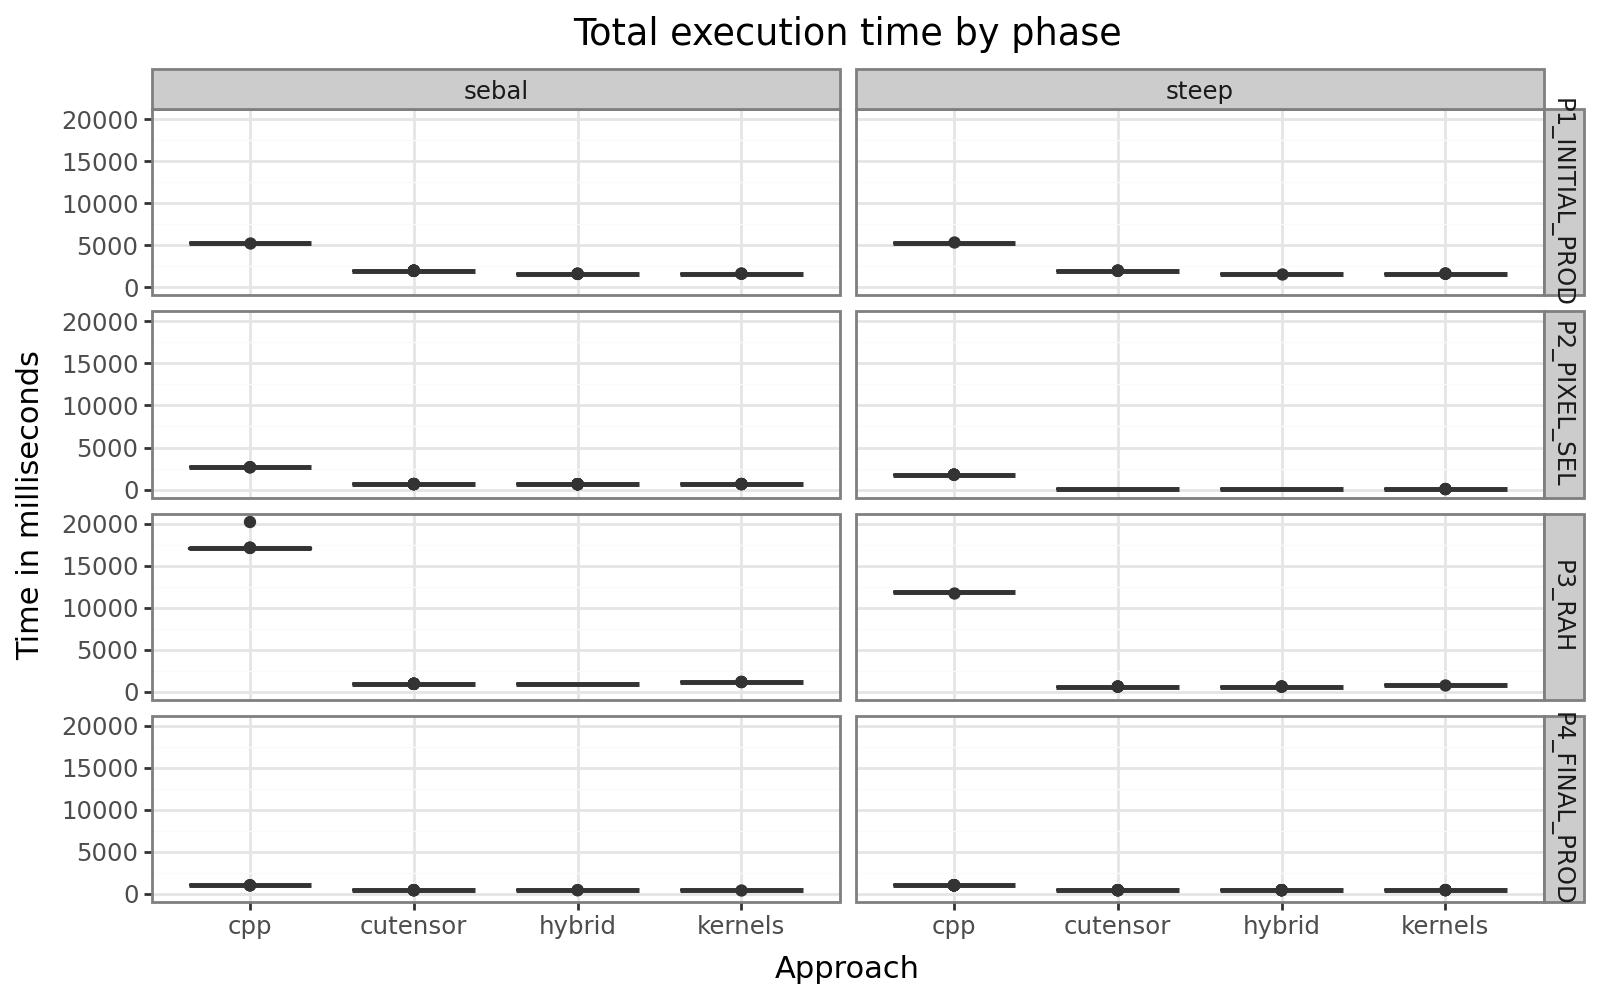

In [18]:
options.figure_size = (8, 5)

# concat sebal and steep 
steep_6502 = steep[steep['SIZE'] == '7295']
sebal_6502 = sebal[sebal['SIZE'] == '7295']
sebal_steep_6502 = pd.concat([sebal_6502, steep_6502], ignore_index=True)
sebal_steep_6502 = sebal_steep_6502[sebal_steep_6502['PHASE'] != 'P0_READ_INPUT']

(ggplot(sebal_steep_6502, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD")
 + labs(title=f"Total execution time by phase", y='Time in milliseconds', x='Approach')
 + theme_bw())

In [19]:
# options.figure_size = (15, 3)

# (ggplot(sebal, aes(x='SIZE', y='TIMESTAMP', color='LANG'))
#  + geom_boxplot()
#  + facet_wrap("~PHASE", ncol=5)
#  + theme_bw())

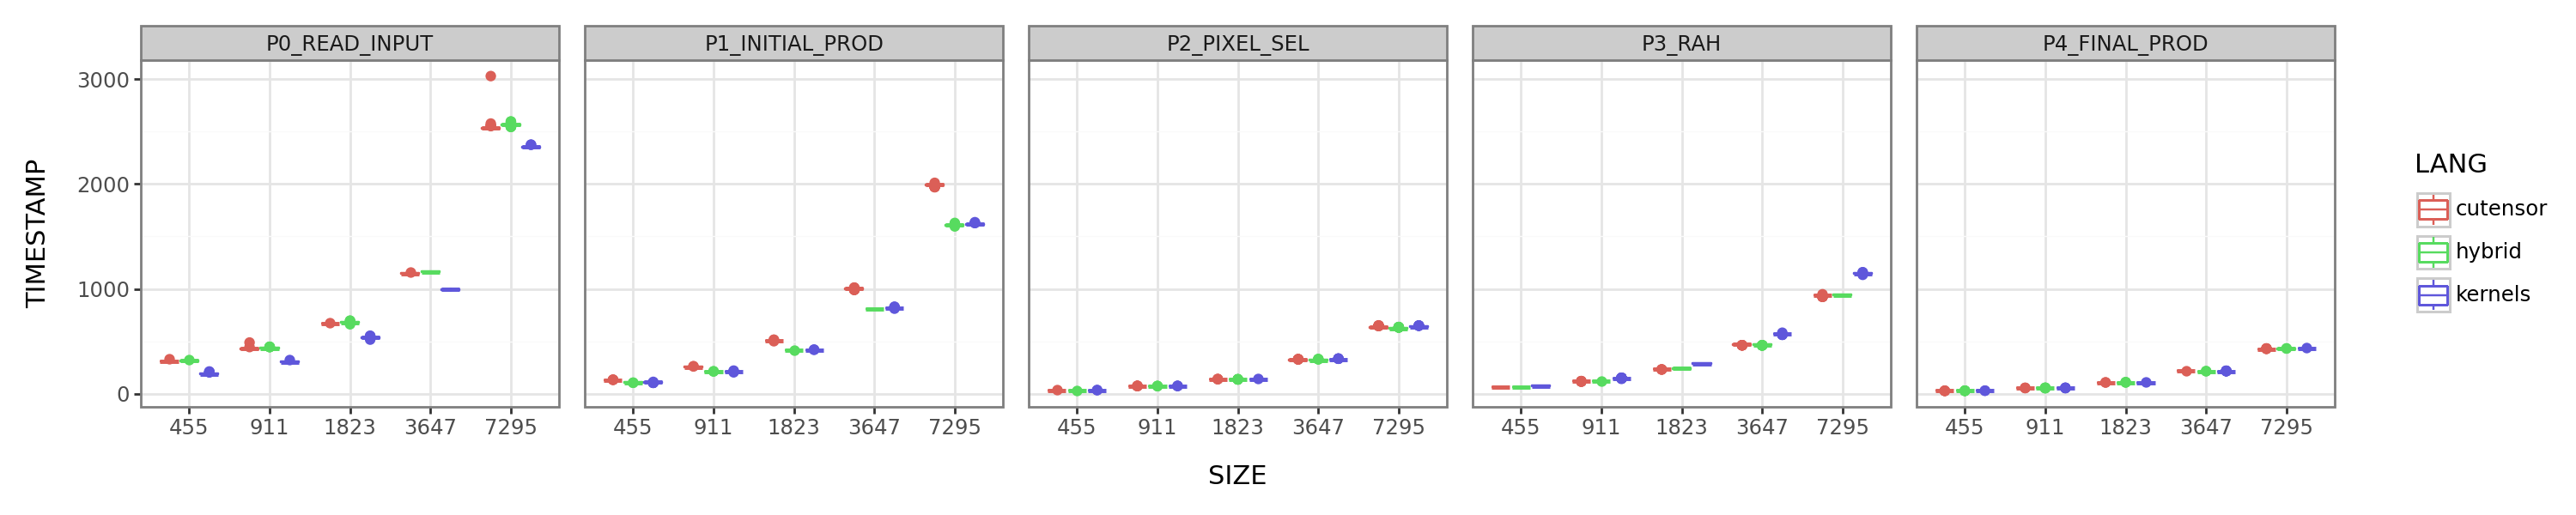

In [20]:
options.figure_size = (15, 3)

combined_sebal = pd.concat([kernels_sebal, hybrid_sebal, cutensor_sebal], ignore_index=True)
(ggplot(combined_sebal, aes(x='SIZE', y='TIMESTAMP', color='LANG'))
 + geom_boxplot()
 + facet_wrap("~PHASE", ncol=5)
 + theme_bw())

### Specific

In [21]:
#select by METHOD 
sebal = combined_dff_specific[combined_dff_specific['METHOD'] == 'sebal']
steep = combined_dff_specific[combined_dff_specific['METHOD'] == 'steep']
sebal['SIZE'] = pd.Categorical(sebal['SIZE'], categories=size_order, ordered=True)
sebal['PHASE'] = pd.Categorical(sebal['PHASE'], categories=phase_order, ordered=True)
steep['SIZE'] = pd.Categorical(steep['SIZE'], categories=size_order, ordered=True)
steep['PHASE'] = pd.Categorical(steep['PHASE'], categories=phase_order, ordered=True)

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']
cutensor_sebal = sebal[sebal['LANG'] == 'cutensor']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']
cutensor_steep = steep[steep['LANG'] == 'cutensor']

/tmp/ipykernel_189344/835454684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/835454684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/835454684.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_189344/

In [22]:
# options.figure_size = (15, 15)

# (ggplot(sebal, aes(x='SIZE', y='TIMESTAMP', color='LANG'))
#  + geom_boxplot()
#  + facet_wrap("~PHASE", scales='free', ncol=7)
#  + theme_bw())

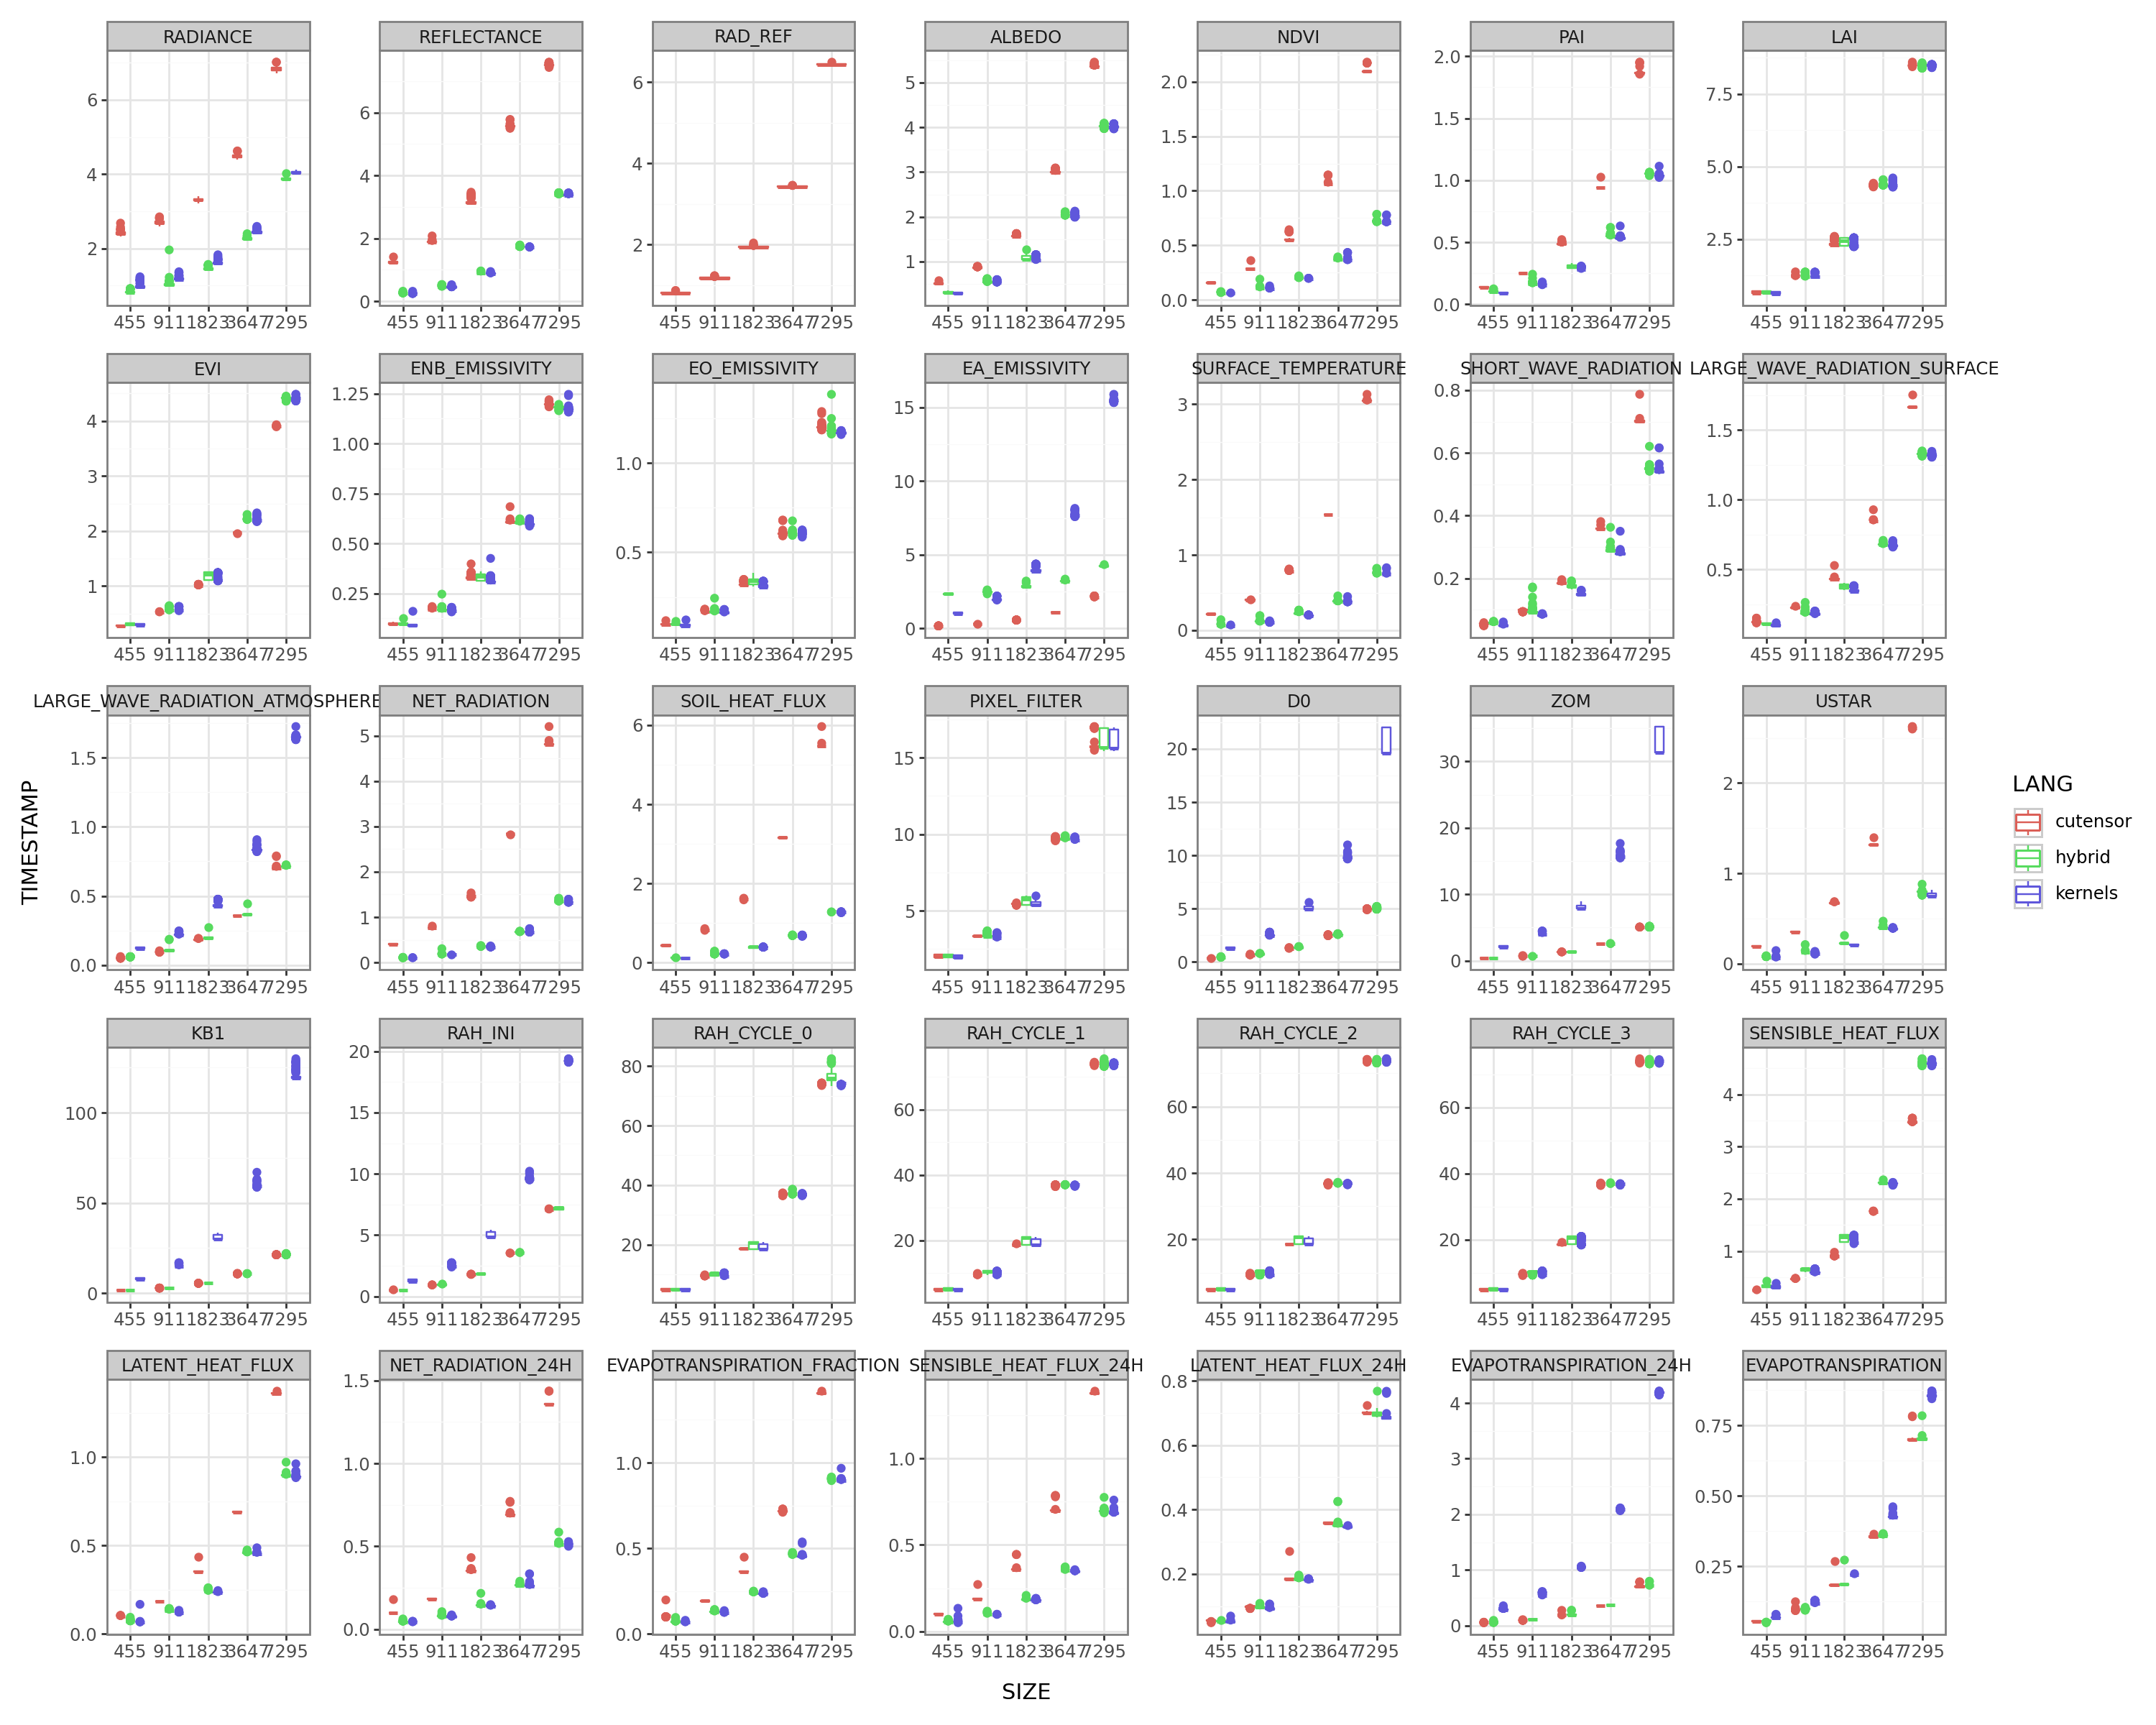

In [23]:
options.figure_size = (15, 12)

combined_sebal = pd.concat([kernels_sebal, hybrid_sebal, cutensor_sebal], ignore_index=True)
(ggplot(combined_sebal, aes(x='SIZE', y='TIMESTAMP', color='LANG'))
 + geom_boxplot()
 + facet_wrap("~PHASE", scales='free', ncol=7)
 + theme_bw())

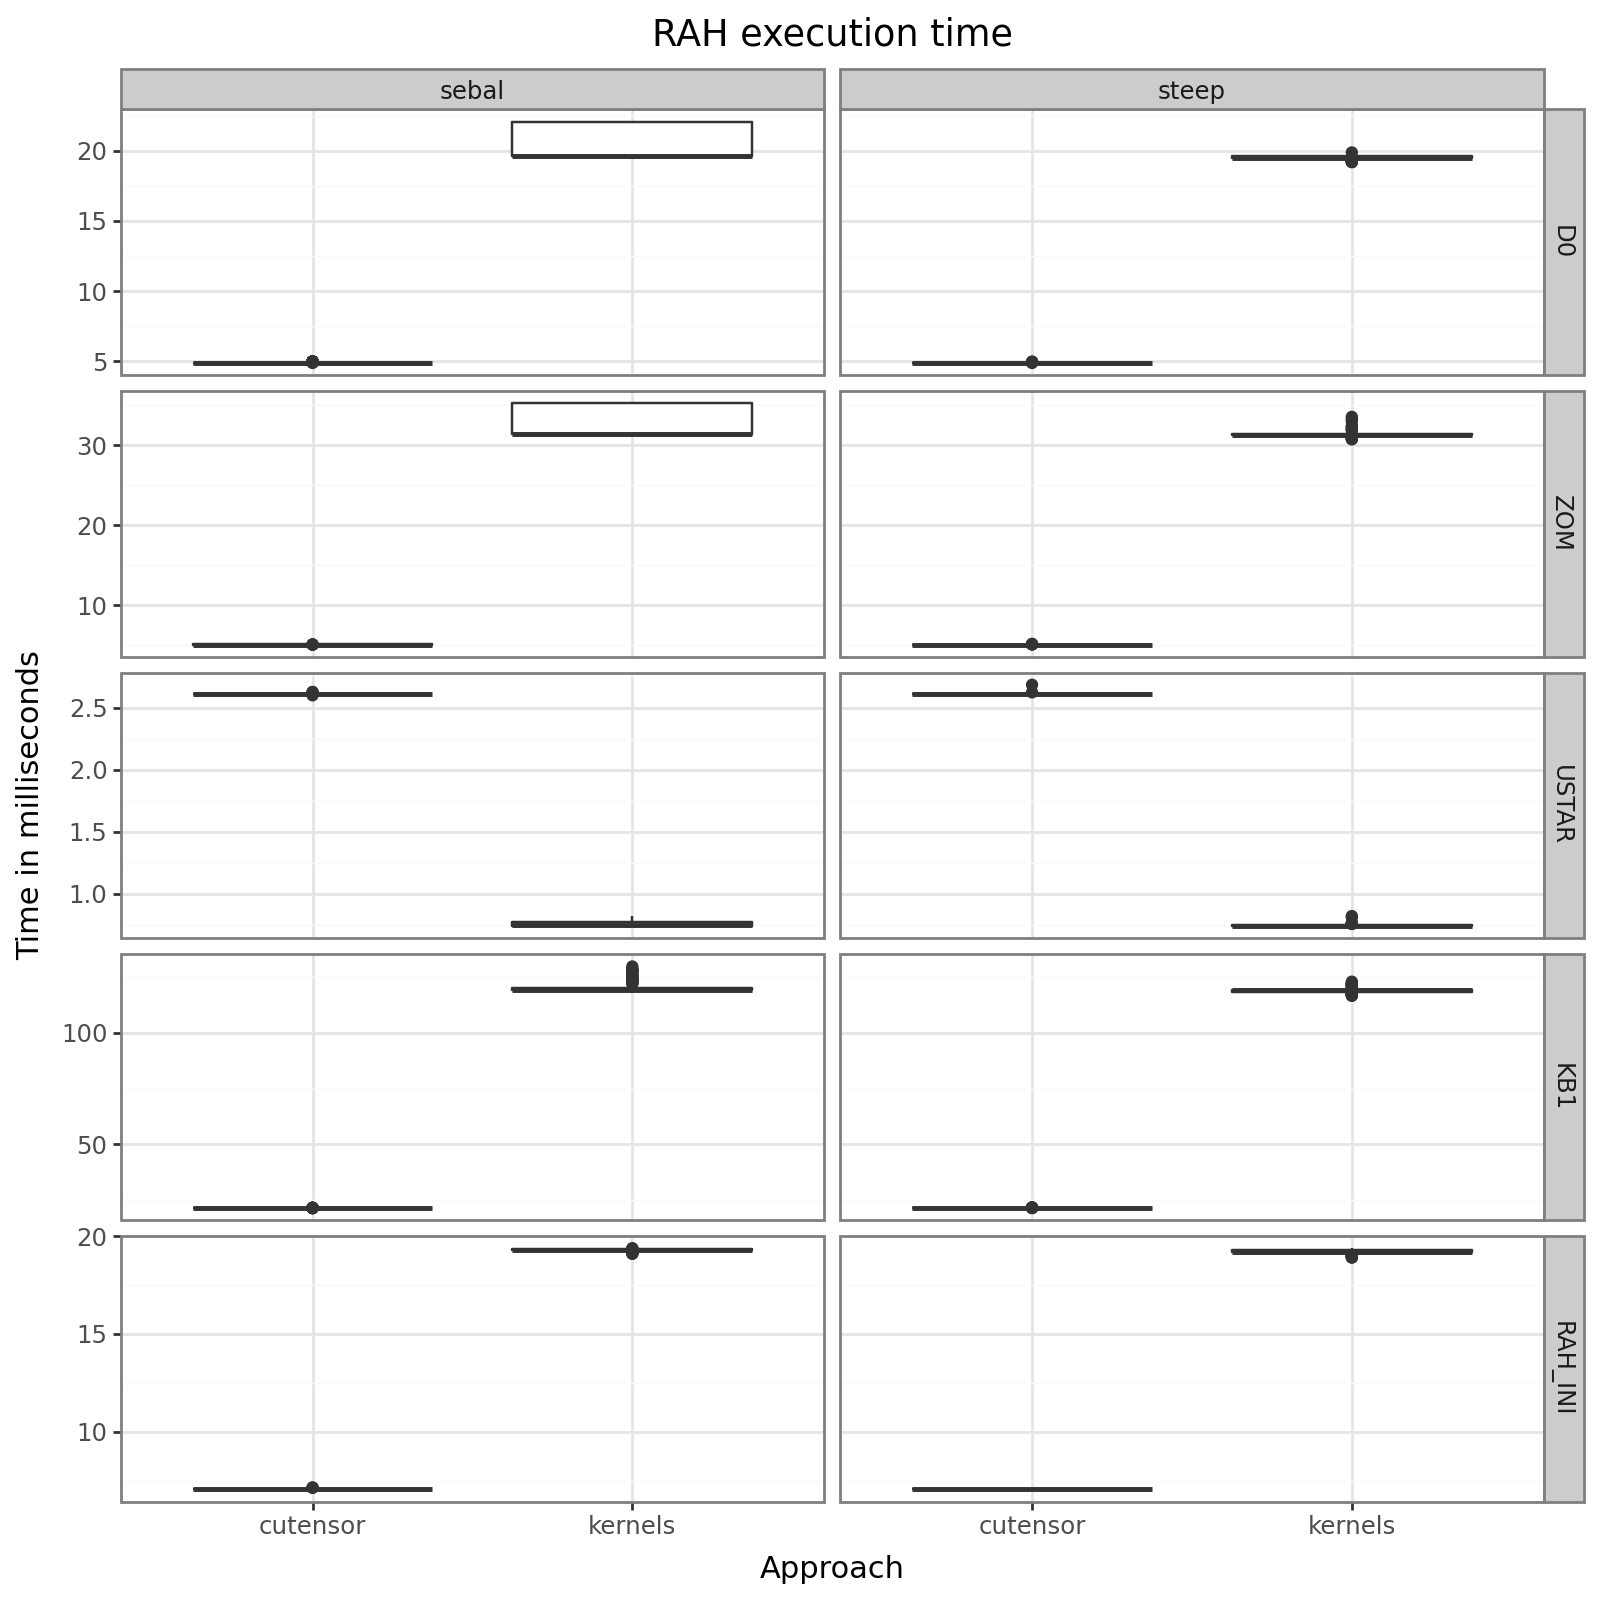

In [44]:
options.figure_size = (8, 8)

filtered_sebal = pd.concat([sebal, steep], ignore_index=True)
filtered_sebal = filtered_sebal[filtered_sebal['PHASE'].isin(['D0','ZOM','USTAR','KB1','RAH_INI'])]
filtered_sebal = filtered_sebal[filtered_sebal['SIZE'] == '7295']
filtered_sebal = filtered_sebal[filtered_sebal['LANG'] != 'cpp']
filtered_sebal = filtered_sebal[filtered_sebal['LANG'] != 'hybrid']

# filtered_sebal = cpp_sebal
# filtered_sebal = filtered_sebal[filtered_sebal['PHASE'].isin(['EA_EMISSIVITY', 'LARGE_WAVE_RADIATION_ATMOSPHERE', 'D0', 'ZOM', 'KB1', 'RAH_INI', 'EVAPOTRANSPIRATION_24H'])]

(ggplot(filtered_sebal, aes(x='LANG', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE~METHOD", scales='free')
 + labs(title=f"RAH execution time", y='Time in milliseconds', x='Approach')
 + theme_bw())

### By language

In [ ]:
# options.figure_size = (10, 10)

# (ggplot(cpp_steep, aes(x='SIZE', y='TIMESTAMP'))
#  + geom_boxplot()
#  + geom_line(aes(group='PHASE'), color='red')
#  + facet_wrap(" ~ PHASE", ncol=4, scales='free')
#  + labs( title=f"{cpp_steep['LANG'].iloc[0]} - {cpp_steep['METHOD'].iloc[0]}")
#  + theme_bw())

In [ ]:
# options.figure_size = (10, 10)

# (ggplot(kernels_steep, aes(x='SIZE', y='TIMESTAMP'))
#  + geom_boxplot()
#  + geom_line(aes(group='PHASE'), color='blue')
#  + facet_wrap(" ~ PHASE", ncol=4, scales='free')
#  + labs( title=f"{kernels_steep['LANG'].iloc[0]} - {kernels_steep['METHOD'].iloc[0]}")
#  + theme_bw())

In [ ]:
# options.figure_size = (10, 10)

# (ggplot(hybrid_steep, aes(x='SIZE', y='TIMESTAMP'))
#  + geom_boxplot()
#  + geom_line(aes(group='PHASE'), color='green')
#  + facet_wrap(" ~ PHASE", ncol=4, scales='free')
#  + labs( title=f"{hybrid_steep['LANG'].iloc[0]} - {hybrid_steep['METHOD'].iloc[0]}")
#  + theme_bw())

### Speedup

In [ ]:
for key, df in dic_summarized.items():
    if '6502x7295' in key and 'cpp' in key:
        df['IDEAL_TIMESTAMP'] = df['TIMESTAMP']
        df['SPEEDUP_REAL'] = 1
        df['SPEEDUP_IDEAL'] = 1
    else:
        size = int(key.split('-')[-1].split('x')[1])
        key_6502 = "cpp-" + key.split('-')[1] + "-6502x7295"
        df['IDEAL_TIMESTAMP'] = dic_summarized[key_6502]['TIMESTAMP'] / (6502 / size)
        df['SPEEDUP_REAL'] = dic_summarized[key_6502]['TIMESTAMP'] / df['TIMESTAMP']
        df['SPEEDUP_IDEAL'] = (6502 / size)

In [ ]:
dic_summarized[f"hybrid-steep-6502x3647"]

,PHASE,TIMESTAMP,experiment,size,approach,IDEAL_TIMESTAMP,SPEEDUP_REAL,SPEEDUP_IDEAL
0,RADIANCE,2.286857,hybrid-steep-6502x3647,3647,hybrid,520.493376,405.776936,1.782835
1,REFLECTANCE,1.730940,hybrid-steep-6502x3647,3647,hybrid,546.811384,563.205325,1.782835
2,ALBEDO,2.033414,hybrid-steep-6502x3647,3647,hybrid,168.200805,147.473344,1.782835
3,NDVI,0.371776,hybrid-steep-6502x3647,3647,hybrid,96.558005,463.039266,1.782835
4,PAI,0.550610,hybrid-steep-6502x3647,3647,hybrid,95.287198,308.533238,1.782835
5,LAI,4.358238,hybrid-steep-6502x3647,3647,hybrid,263.551103,107.811506,1.782835
6,EVI,2.209199,hybrid-steep-6502x3647,3647,hybrid,104.562316,84.382332,1.782835
7,ENB_EMISSIVITY,0.604445,hybrid-steep-6502x3647,3647,hybrid,79.489751,234.458365,1.782835
8,EO_EMISSIVITY,0.603479,hybrid-steep-6502x3647,3647,hybrid,79.259424,234.153102,1.782835
9,EA_EMISSIVITY,3.215582,hybrid-steep-6502x3647,3647,hybrid,460.143353,255.120187,1.782835


In [ ]:
for key, df in dic_summarized.items():
    df['LANG'] = key.split('-')[0]
    df['METHOD'] = key.split('-')[1] 

summarized_dff = pd.concat(dic_summarized.values(), ignore_index=True)
summarized_dff_specific = summarized_dff[~summarized_dff['PHASE'].str.match(r'^P.\_') & (summarized_dff['PHASE'] != 'P_TOTAL')]
summarized_dff_p = summarized_dff[summarized_dff['PHASE'].str.match(r'^P.\_')]

In [ ]:
#select by METHOD 
sebal = summarized_dff_p[summarized_dff_p['METHOD'] == 'sebal']
steep = summarized_dff_p[summarized_dff_p['METHOD'] == 'steep']

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']

In [ ]:
sebal

,PHASE,TIMESTAMP,experiment,size,approach,IDEAL_TIMESTAMP,SPEEDUP_REAL,SPEEDUP_IDEAL,LANG,METHOD
34,P0_READ_INPUT,450.154955,cpp-sebal-6502x1823,1823,cpp,599.773528,4.752100,3.566648,cpp,sebal
35,P1_INITIAL_PROD,1356.843939,cpp-sebal-6502x1823,1823,cpp,1478.388246,3.886144,3.566648,cpp,sebal
36,P2_PIXEL_SEL,679.098133,cpp-sebal-6502x1823,1823,cpp,738.053899,3.876286,3.566648,cpp,sebal
37,P3_RAH,4347.798209,cpp-sebal-6502x1823,1823,cpp,4788.148413,3.927883,3.566648,cpp,sebal
38,P4_FINAL_PROD,251.612841,cpp-sebal-6502x1823,1823,cpp,279.727855,3.965183,3.566648,cpp,sebal
...,...,...,...,...,...,...,...,...,...,...
1374,P0_READ_INPUT,2566.167826,hybrid-sebal-6502x7295,7295,hybrid,2400.081124,0.833609,0.891295,hybrid,sebal
1375,P1_INITIAL_PROD,1607.667505,hybrid-sebal-6502x7295,7295,hybrid,5915.985878,3.279839,0.891295,hybrid,sebal
1376,P2_PIXEL_SEL,622.819307,hybrid-sebal-6502x7295,7295,hybrid,2953.430167,4.226553,0.891295,hybrid,sebal
1377,P3_RAH,940.859714,hybrid-sebal-6502x7295,7295,hybrid,19160.473217,18.151103,0.891295,hybrid,sebal


In [ ]:
# options.figure_size = (15, 3)

# sebal_p3 = sebal[sebal['PHASE'] == 'P3_RAH']

# (ggplot(sebal_p3, aes(x='size', y='SPEEDUP_REAL', color='LANG'))
#         + geom_line(aes(group='LANG'))
#         + geom_line(aes(x='size', y='SPEEDUP_IDEAL'), linetype='dashed', color='black')
#         + facet_wrap(" ~ PHASE", ncol=5, scales='free')
#         + labs(title=f"{sebal['METHOD'].iloc[0]}")
#         # + scale_x_reverse()
#         + theme_bw())

In [ ]:
#select by METHOD 
sebal = summarized_dff_p[summarized_dff_p['METHOD'] == 'sebal']
steep = summarized_dff_p[summarized_dff_p['METHOD'] == 'steep']

# concat sebal and steep 
steep_6502 = steep[steep['size'] == 7295]
sebal_6502 = sebal[sebal['size'] == 7295]
sebal_steep_filtered = pd.concat([sebal_6502, steep_6502]).reset_index(drop=True)

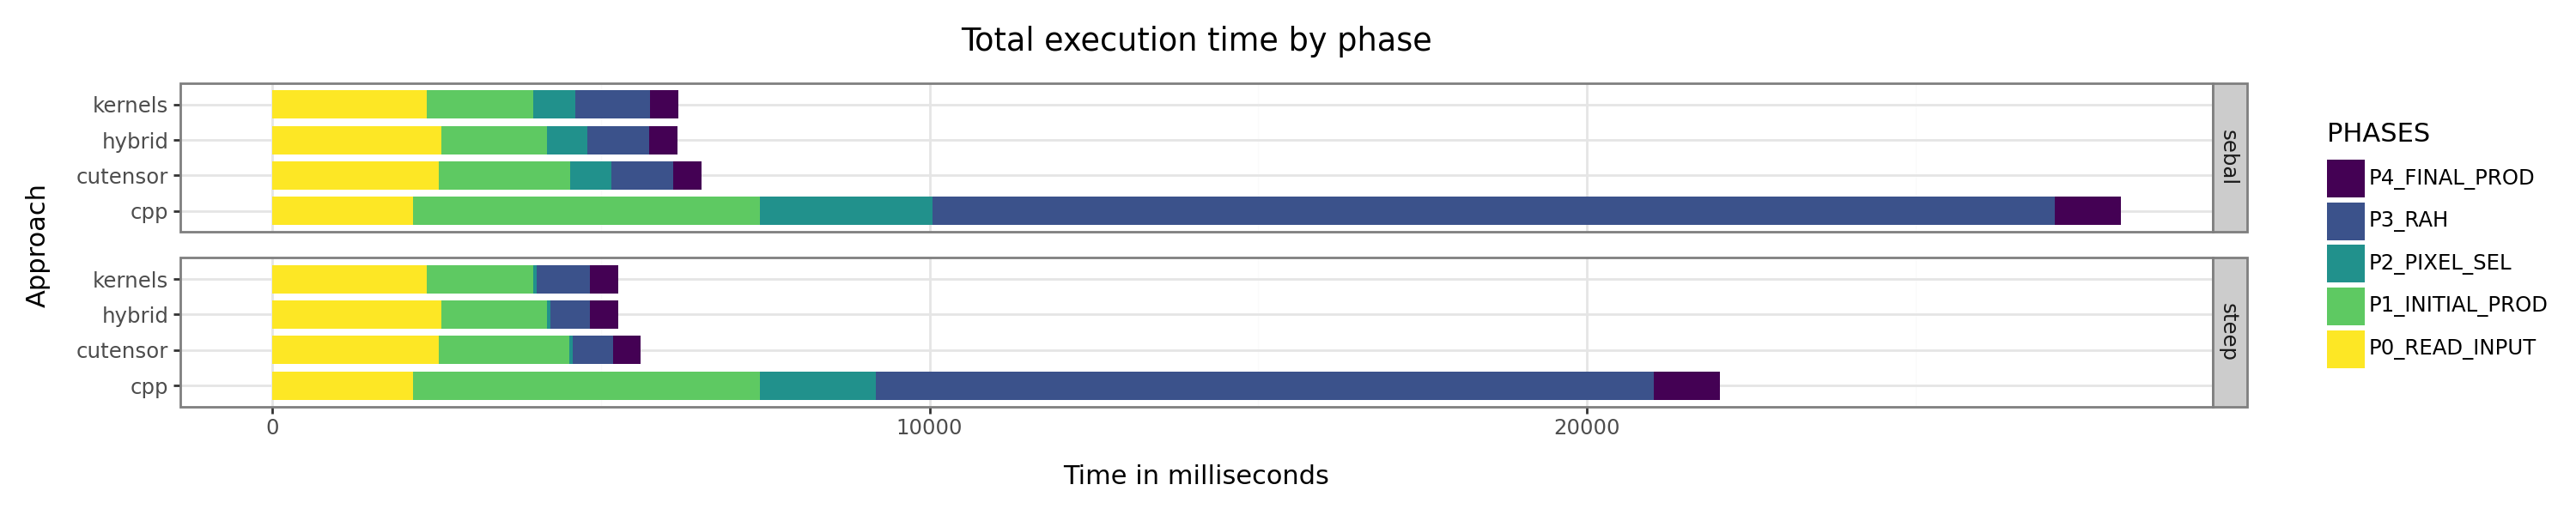

In [ ]:
main_phases = ['P4_FINAL_PROD', 'P3_RAH', 'P2_PIXEL_SEL', 'P1_INITIAL_PROD', 'P0_READ_INPUT']
xxx = sebal_steep_filtered[sebal_steep_filtered['PHASE'].isin(main_phases)].copy()
xxx['PHASE'] = pd.Categorical(xxx['PHASE'], categories=main_phases)

(ggplot(xxx, aes(x='LANG', y='TIMESTAMP', fill='PHASE'))
        + geom_bar(stat='identity', position='stack', width=0.8)
        + facet_grid('METHOD ~ .')
        + labs(title=f"Total execution time by phase", y='Time in milliseconds', x='Approach')
        + guides(fill=guide_legend(title="PHASES"))
        + coord_flip()
        + theme_bw())

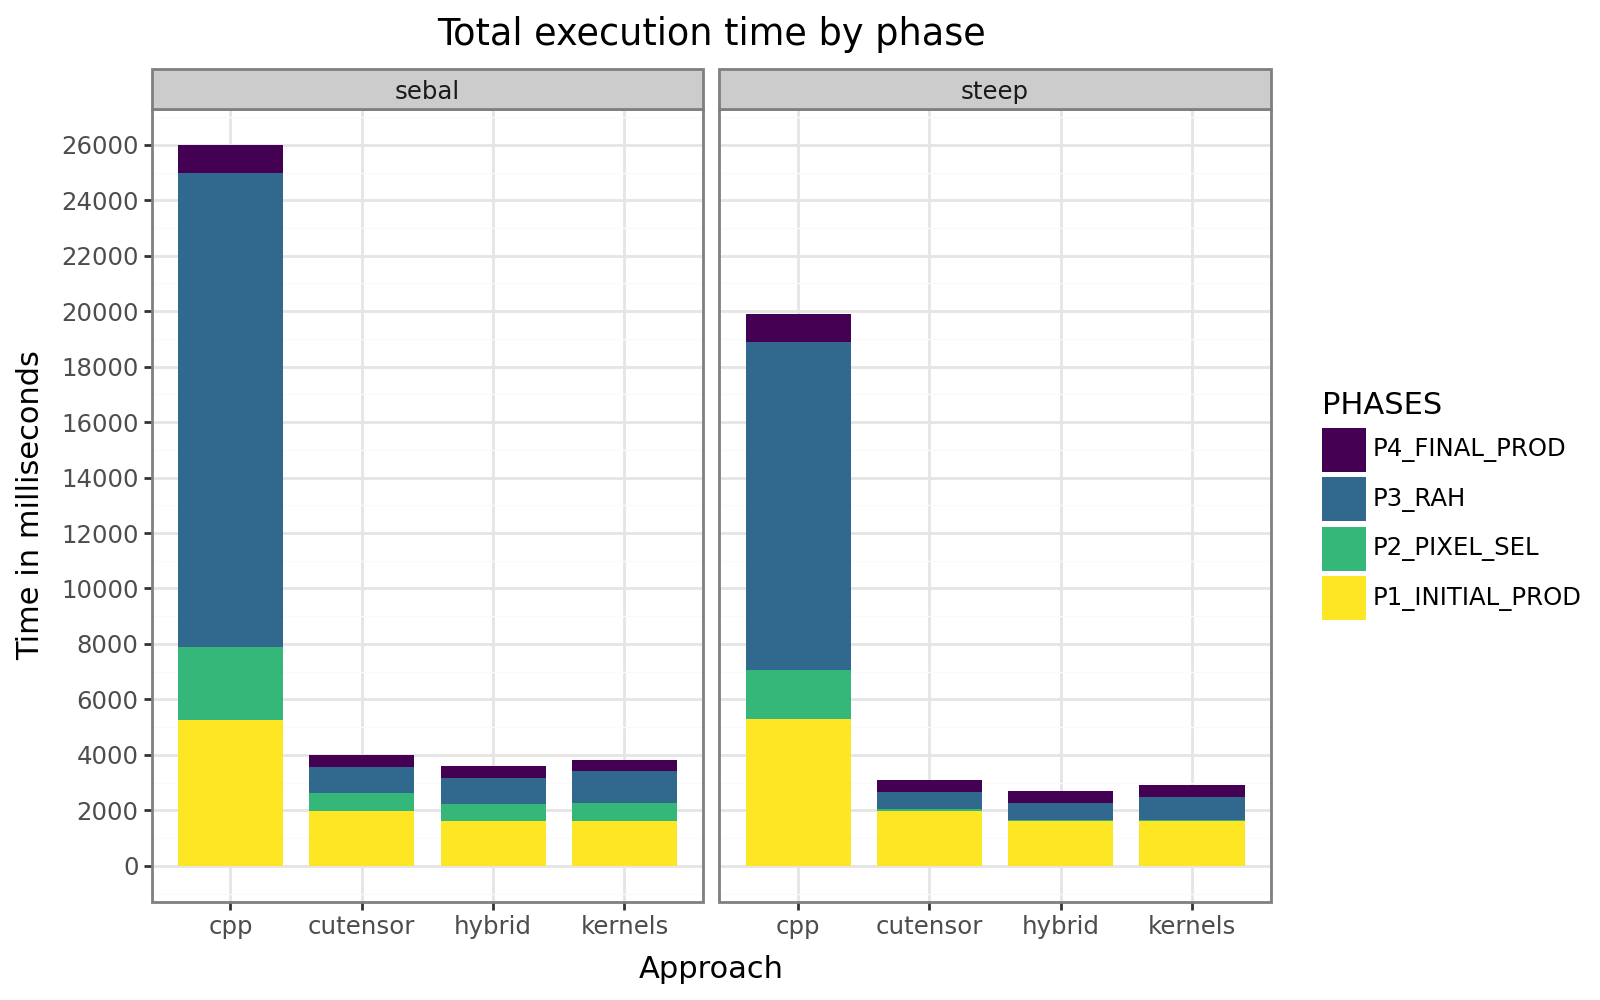

In [ ]:
options.figure_size = (8, 5)

main_phases = ['P4_FINAL_PROD', 'P3_RAH', 'P2_PIXEL_SEL', 'P1_INITIAL_PROD']
xxx2 = sebal_steep_filtered[sebal_steep_filtered['PHASE'].isin(main_phases)].copy()
xxx2['PHASE'] = pd.Categorical(xxx2['PHASE'], categories=main_phases)
# xxx2 = xxx2[xxx2['LANG'] != 'cpp']

(ggplot(xxx2, aes(x='LANG', y='TIMESTAMP', fill='PHASE'))
        + geom_bar(stat='identity', position='stack', width=0.8)
        + facet_grid('.~METHOD')
        + labs(title=f"Total execution time by phase", y='Time in milliseconds', x='Approach')
        + guides(fill=guide_legend(title="PHASES"))
        + scale_y_continuous(breaks=range(0, 30000, 2000))
        # + coord_flip()
        + theme_bw())

## Hardcoded

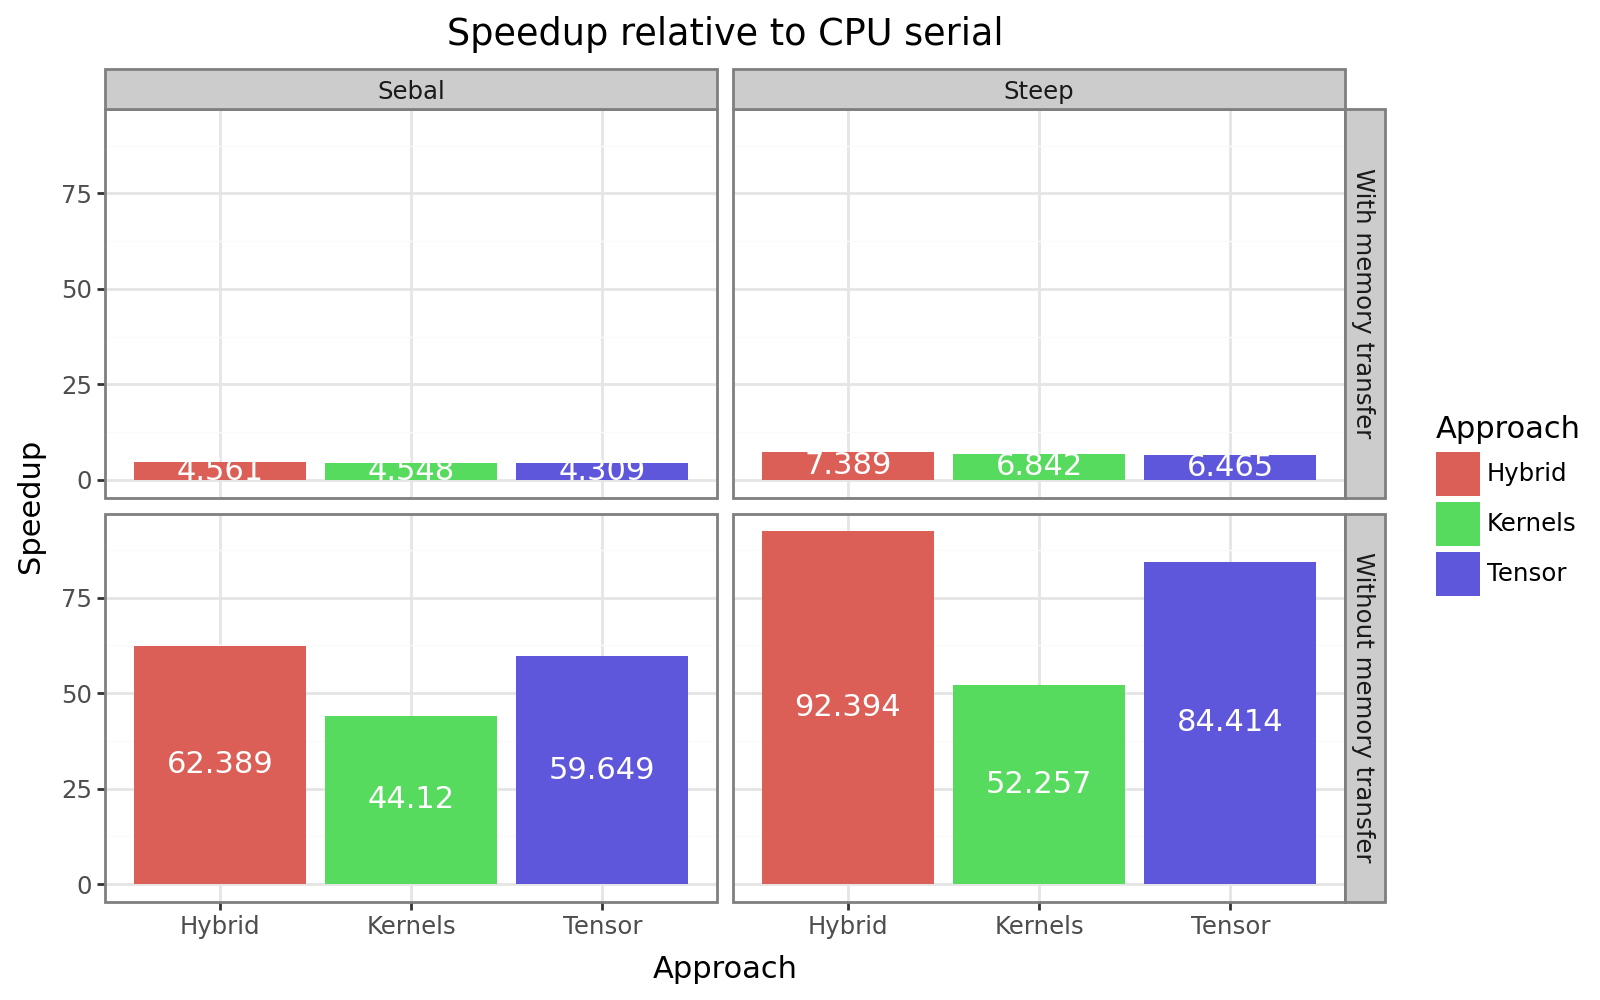

In [ ]:
data = {
    'Approach': ['Kernels', 'Tensor', 'Hybrid', 'Kernels', 'Tensor', 'Hybrid', 'Kernels', 'Tensor', 'Hybrid', 'Kernels', 'Tensor', 'Hybrid'],
    'Speedup': [44.120, 59.649, 62.389, 52.257, 84.414, 92.394, 4.548, 4.309, 4.561, 6.842, 6.465, 7.389],
    'Type': ['Sebal', 'Sebal', 'Sebal', 'Steep', 'Steep', 'Steep', 'Sebal', 'Sebal', 'Sebal', 'Steep', 'Steep', 'Steep'],
    'memory': ['Without memory transfer', 'Without memory transfer', 'Without memory transfer', 'Without memory transfer', 'Without memory transfer', 'Without memory transfer',
               'With memory transfer', 'With memory transfer', 'With memory transfer', 'With memory transfer', 'With memory transfer', 'With memory transfer']
}

df = pd.DataFrame(data)

# Criar o gráfico
(ggplot(df, aes(x='Approach', y='Speedup', fill='Approach')) +
    geom_bar(stat='identity') +
    geom_text(aes(label='Speedup'), position=position_stack(vjust=0.5), color='white') +
    facet_grid('memory~Type') +
    labs(title='Speedup relative to CPU serial', x='Approach', y='Speedup') +
    theme_bw())

In [ ]:
# Dados para steep com memoria
steep_com_memoria = {
    "Phase": [
        "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD",
        "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL",
        "P3_RAH", "P3_RAH", "P3_RAH", "P3_RAH",
        "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD",
    ],

    "Approach": [
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
    ],

    "Time": [
        5278.995,	1613.144,	1990.390,	1607.109,
        1763.473,	52.471,	    52.126,	    51.562,
        11838.208,	809.757,	609.147,	604.891,
        1008.657,	431.367,	424.812,	428.276,
    ]
}

# Dados para steep sem memória
steep_sem_memoria = {
    "Phase": [
        "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD",
        "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL",
        "P3_RAH", "P3_RAH", "P3_RAH", "P3_RAH",
        "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD",
    ],

    "Approach": [
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
    ],

    "Time": [
        5278.888, 50.617, 57.004, 38.554,
        1717.068, 15.383, 15.507, 15.623,
        11783.550, 299.248, 150.835, 150.263,
        1008.60, 13.422, 11.073, 9.732,
    ],

}

# Dados para sebal com memória
sebal_com_memoria = {
    "Phase": [
        "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD",
        "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL",
        "P3_RAH", "P3_RAH", "P3_RAH", "P3_RAH",
        "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD",
    ],

    "Approach": [
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
    ],

    "Time": [
        5272.89,	1615.22,	1991.73,	1607.67,
        2632.38,	639.58,	    635.03,	    622.82,
        17077.64,	1145.16,	937.17,	    940.86,
        997.69,	    431.38,	    425.04,	    428.31,
    ]
}

# Dados para sebal sem memória
sebal_sem_memoria = {
    "Phase": [
        "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD", "P1_INITIAL_PROD",
        "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL", "P2_PIXEL_SEL",
        "P3_RAH", "P3_RAH", "P3_RAH", "P3_RAH",
        "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD", "P4_FINAL_PROD",
    ],

    "Approach": [
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
        "CPP", "KERNELS", "TENSOR", "HYBRID",
    ],

    "Time": [
        5272.784, 50.749, 57.022, 38.563,
        1853.729, 15.954, 15.98, 16.012,
        11503.647, 341.862, 189.274, 190.657,
        6272.01, 156.353, 157.9, 156.412,
    ],
}

steep_com_memoria_df = pd.DataFrame(steep_com_memoria)
steep_sem_memoria_df = pd.DataFrame(steep_sem_memoria)
sebal_com_memoria_df = pd.DataFrame(sebal_com_memoria)
sebal_sem_memoria_df = pd.DataFrame(sebal_sem_memoria)

steep_com_memoria_df["Method"] = "Steep"
steep_sem_memoria_df["Method"] = "Steep"
sebal_com_memoria_df["Method"] = "Sebal"
sebal_sem_memoria_df["Method"] = "Sebal"

steep_com_memoria_df["Memory"] = "With memory transfer"
steep_sem_memoria_df["Memory"] = "Without memory transfer"
sebal_com_memoria_df["Memory"] = "With memory transfer"
sebal_sem_memoria_df["Memory"] = "Without memory transfer"

# concat all data
final_data = pd.concat([
    steep_com_memoria_df,
    steep_sem_memoria_df,
    sebal_com_memoria_df,
    sebal_sem_memoria_df
], ignore_index=True)

In [ ]:
final_data

,Phase,Approach,Time,Method,Memory
0,P1_INITIAL_PROD,CPP,5278.995,Steep,With memory transfer
1,P1_INITIAL_PROD,KERNELS,1613.144,Steep,With memory transfer
2,P1_INITIAL_PROD,TENSOR,1990.390,Steep,With memory transfer
3,P1_INITIAL_PROD,HYBRID,1607.109,Steep,With memory transfer
4,P2_PIXEL_SEL,CPP,1763.473,Steep,With memory transfer
...,...,...,...,...,...
59,P3_RAH,HYBRID,190.657,Sebal,Without memory transfer
60,P4_FINAL_PROD,CPP,6272.010,Sebal,Without memory transfer
61,P4_FINAL_PROD,KERNELS,156.353,Sebal,Without memory transfer
62,P4_FINAL_PROD,TENSOR,157.900,Sebal,Without memory transfer


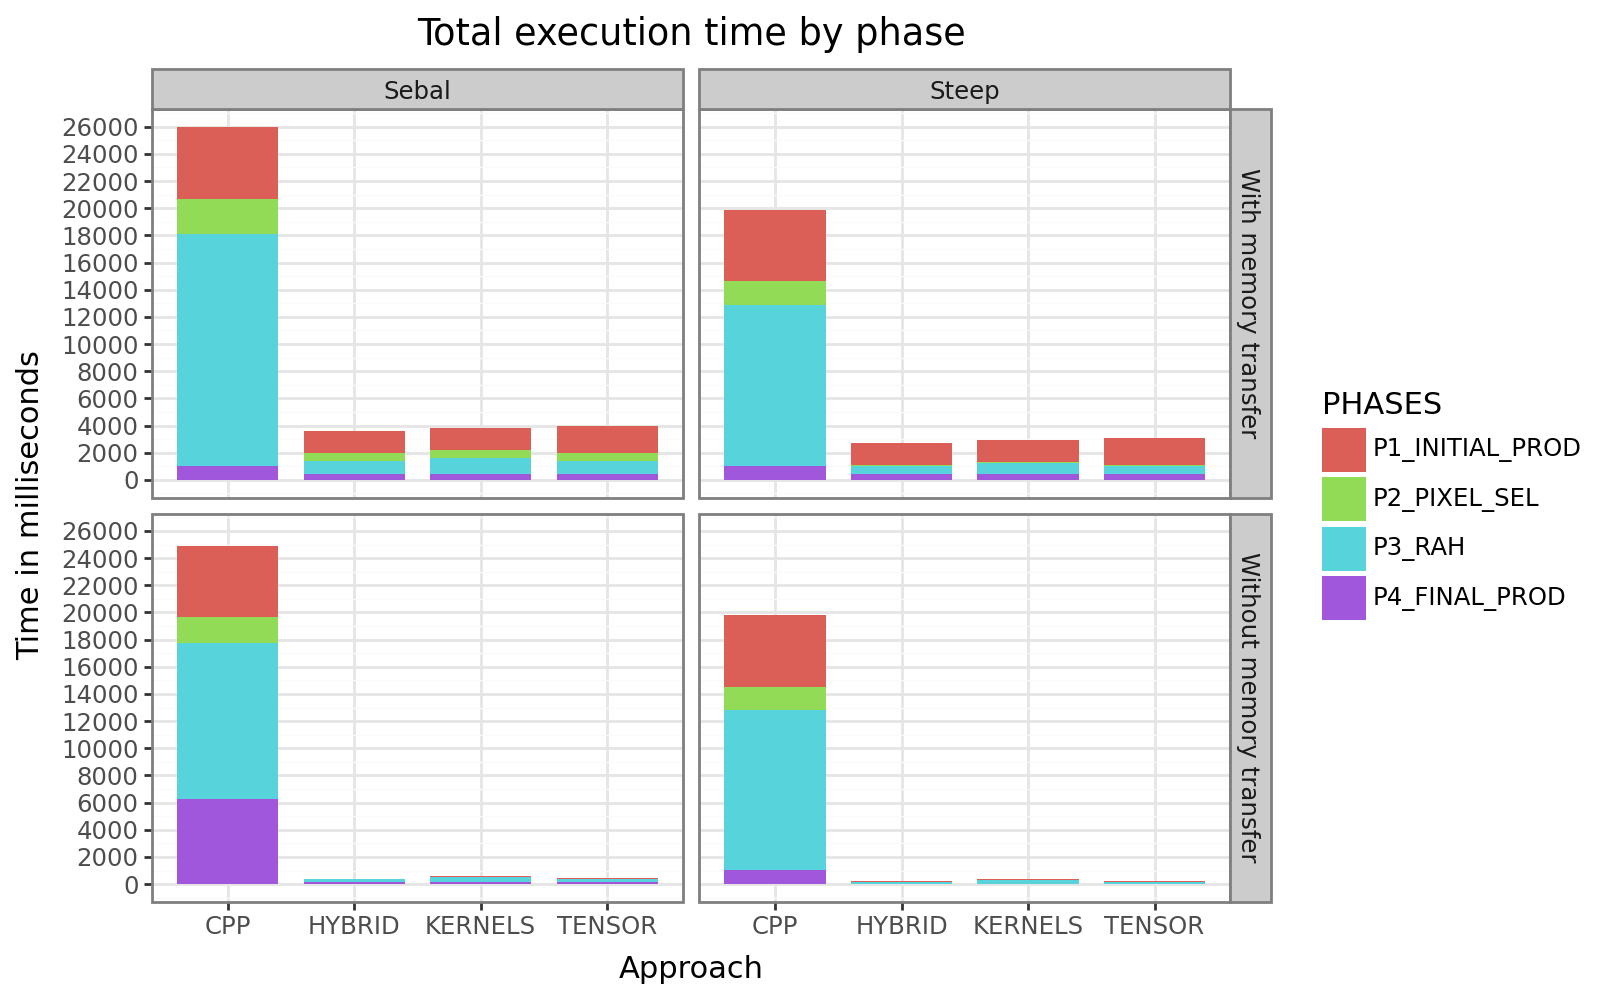

In [ ]:
(ggplot(final_data, aes(x='Approach', y='Time', fill='Phase'))
        + geom_bar(stat='identity', position='stack', width=0.8)
        + facet_grid('Memory~Method')
        + labs(title=f"Total execution time by phase", y='Time in milliseconds', x='Approach')
        + guides(fill=guide_legend(title="PHASES"))
        + scale_y_continuous(breaks=range(0, 30000, 2000))
        # + coord_flip()
        + theme_bw())